In [6]:
from pycbc.waveform import get_td_waveform      # imports a time domain waveform module
import matplotlib.pyplot as plt

In [2]:
time = 32                   # length of the signal
rate = 4096                 # sampling rate of the signal (one second of data has 4096 points)
f_low = 20                  # low-frequency threshold
tlen = rate * time          # length of the wave array is the product of total duration and sampling rate

In [3]:
sp, sc = get_td_waveform(approximant="SpinTaylorT4", mass1=5, mass2=5,
                        f_lower=f_low, delta_t=1.0/rate, inclination=0, phase_order=7,
                         amplitude_order=0, distance=75)

In [4]:
sp.resize(tlen)
sc.resize(tlen)

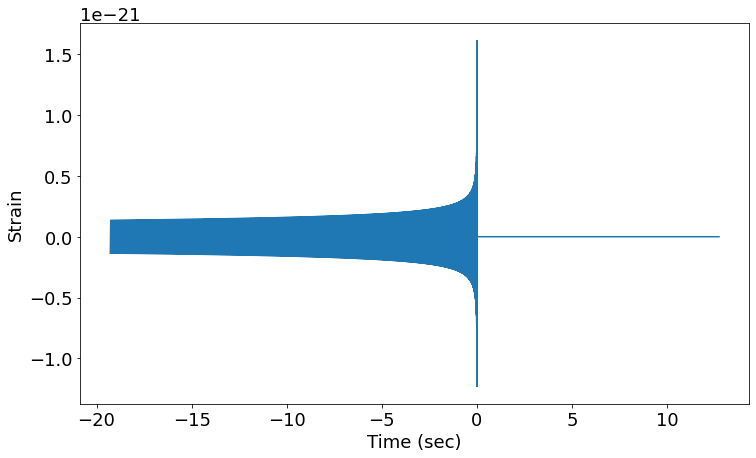

In [7]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 7))
plt.plot(sp.sample_times, sp)
plt.xlabel("Time (sec)")
plt.ylabel("Strain")
plt.show()